# Foldgraph
Roberto Toro, April 2019

In [133]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 

# module_path = "/usr/local/lib/python3.7/site-packages"
module_path = "/Users/roberto/.pyenv/versions/3.7.3/lib/python3.7/site-packages"
if module_path not in sys.path:
    sys.path.append(module_path)
import gmatch4py as gm
from gmatch4py.helpers.general import parsenx2graph

## Graph edit distance test

Test from gmatch4py website.

Creates two complete bipartite graphs K_{n_1,n_2}. Each graph is composed of two partitions with n_1 nodes in the first and n_2 nodes in the second. Each node in the first is connected to each node in the second.

Graph edit distance matrix:
[[ 0. 14.]
 [10.  0.]]
Edit path:
[2. 0. 0. 0. 0. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7.]
Munkres assignment:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), array([ 5,  1,  2,  3,  4,  0,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18,  9]))


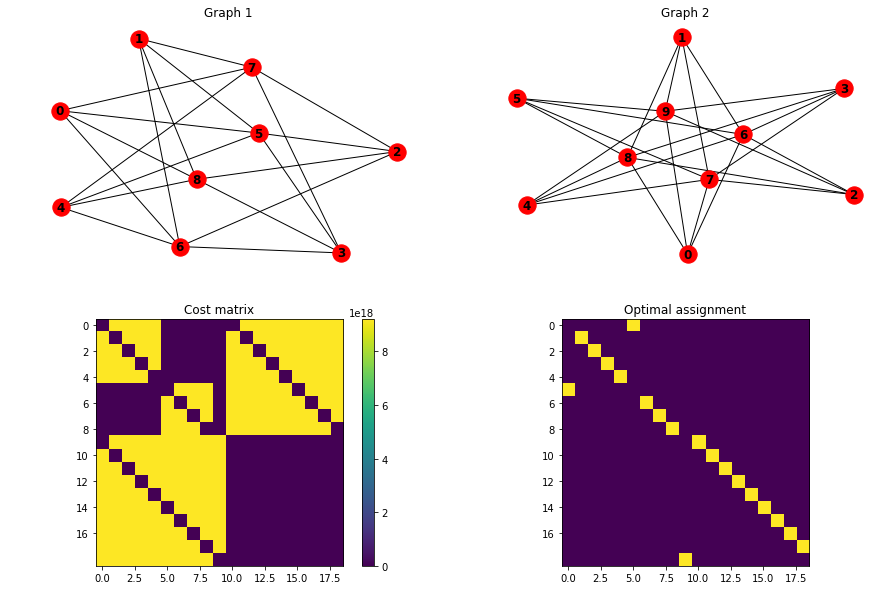

In [134]:
g1=nx.complete_bipartite_graph(5,4) 
g2=nx.complete_bipartite_graph(6,4)

plt.figure(figsize=(15,10))
plt.subplot(221);
nx.draw(g1, with_labels=True, font_weight='bold')
plt.title("Graph 1")
plt.subplot(222);
nx.draw(g2, with_labels=True, font_weight='bold')
plt.title("Graph 2")

# parse graphs in gmatch4py format
GS = parsenx2graph([g1,g2])

# weights are for node_del, node_ins, edge_del, edge_ins
# here, all edit costs are equal to 1
ged=gm.GraphEditDistance(1,1,1,1)

# compute graph edit distance
result=ged.compare([g1,g2],None) 
print("Graph edit distance matrix:")
print(result)

# compute optimal edit path
edit_path, cost_matrix, munkres = ged.edit_path(GS[0],GS[1])
print ("Edit path:")
print(edit_path)
print("Munkres assignment:")
print(munkres)

# plot cost matrix
plt.subplot(223);
plt.imshow(cost_matrix)
plt.title("Cost matrix")
plt.colorbar()
plt.yticks(np.arange(0, 18, 2, dtype=np.int))

# plot optimal assignment
mat = np.zeros((edit_path.shape[0],edit_path.shape[0]))
for i in range(edit_path.shape[0]):
    mat[munkres[0][i],munkres[1][i]] = 1
plt.subplot(224);
plt.imshow(mat)
plt.title("Optimal assignment")
plt.yticks(np.arange(0, 18, 2, dtype=np.int));


## A further example.

The optimal assignment matrix encodes the edits needed to convert one graph into the other. Its structure (from issue #7 in the gmatch4py GitHub repository) is like this:

![assignment matrix](ged.png)

The top-left rectangle indicates substitutions, the top-right rectangle deletions, and the bottom-left rectangle insertions. In this case, node A1 is assigned to node A2, B1 to B2, and node C is inserted. The cost of this last operation is 2: 1 for the insertion of the new node, and 1 for the creation of an edge. The following code reproduces the example:

[[0. 3.]
 [3. 0.]]
[0. 1. 0. 0. 2.]
(array([0, 1, 2, 3, 4]), array([0, 1, 3, 4, 2]))


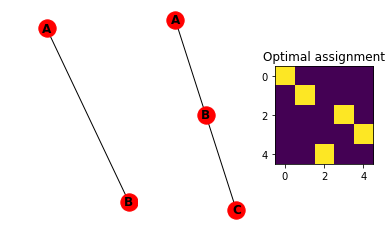

In [135]:
G1 = nx.Graph()
G1.add_edges_from([['A', 'B']])
n1=G1.number_of_nodes()

G2 = nx.Graph()
G2.add_edges_from([['A','B'], ['B','C']])
n2=G2.number_of_nodes()

# plot the graphs
plt.figure()
plt.subplot(131);
nx.draw(G1, with_labels=True, font_weight='bold')
plt.subplot(132);
nx.draw(G2, with_labels=True, font_weight='bold')

# compute GED
GS = parsenx2graph([G1,G2])
result=ged.compare([G1,G2],None) 
print(result)
edit_path, cost_matrix, munkres = ged.edit_path(GS[0],GS[1])
print(edit_path)
print(munkres)

# plot optimal assignment
mat = np.zeros((edit_path.shape[0],edit_path.shape[0]))
for i in range(edit_path.shape[0]):
    mat[munkres[0][i],munkres[1][i]] = 1
plt.subplot(133);
plt.imshow(mat)
plt.title("Optimal assignment");


## Graph edit distance on foldgraphs

Number of nodes: 67
Number of edges: 92
Nodes in G1: 28
Nodes in G2: 39


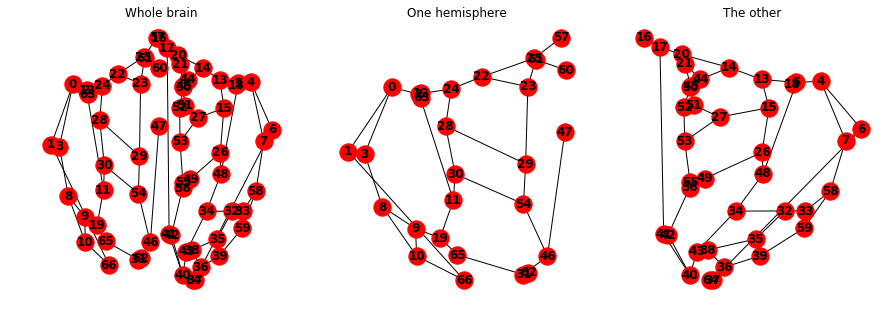

In [136]:
# Read a fold graph
fg=!cat ../data/derived/flat/baboon/polar_graph.txt
nv,_,ne = [int(x) for x in fg[0].split(" ")]
v = np.array([[float(y) for y in x.split(" ")] for x in fg[1:nv+1]])[:,:2]
e = np.array([[int(y) for y in x.split(" ")] for x in fg[1+nv:-1]])

G = nx.Graph()
G.add_edges_from(e)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# split hemispheres
C = nx.connected_components(G)
G1 = G.subgraph(next(C))
G2 = G.subgraph(next(C))
n1=G1.number_of_nodes()
n2=G2.number_of_nodes()
print("Nodes in G1:", n1)
print("Nodes in G2:", n2)

plt.figure(figsize=(15,5))
plt.subplot(131);
plt.title("Whole brain")
nx.draw(G, v, with_labels=True, font_weight='bold')
plt.subplot(132);
nx.draw(G1, v, with_labels=True, font_weight='bold')
plt.title("One hemisphere")
plt.subplot(133);
nx.draw(G2, v, with_labels=True, font_weight='bold')
plt.title("The other");

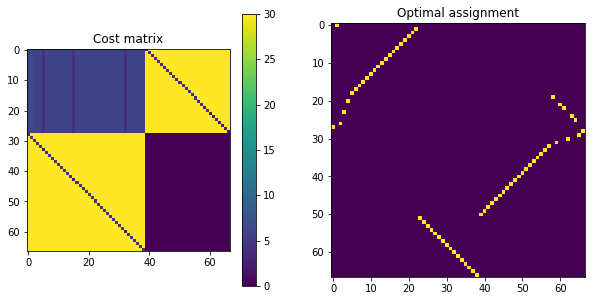

In [137]:
GS = parsenx2graph([G1,G2])
ged=gm.GraphEditDistance(1,1,1,1)

result=ged.compare([G1,G2],None)
sim = ged.similarity(result)
dis = ged.distance(result)

edit_path, cost_matrix, munkres = ged.edit_path(GS[0],GS[1])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cost_matrix, vmax=30)
plt.title("Cost matrix")
plt.colorbar();

mat = np.zeros((edit_path.shape[0],edit_path.shape[0]))
for i in range(edit_path.shape[0]):
    mat[munkres[0][i],munkres[1][i]] = 1
plt.subplot(122);
plt.imshow(mat)
plt.title("Optimal assignment");

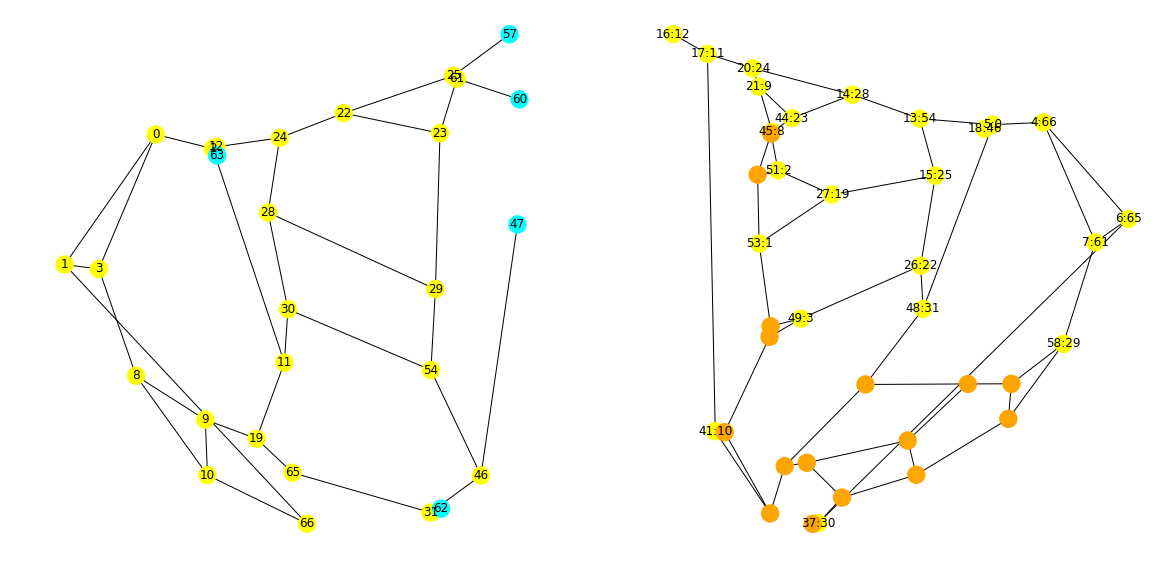

In [162]:
nlab1 = list(G1.nodes)
nlab2 = list(G2.nodes)

colormap1 = []
for i in range(n1):
    if munkres[1][i] < n2:
        colormap1.append('yellow') # substitute
    else:
        colormap1.append('cyan') # delete

colormap2=['blue' for x in range(n2)]
labels = {}
for i in range(n1 + n2):
    if munkres[0][i] < n1:
        if munkres[1][i] < n2:
            colormap2[munkres[1][i]] = 'yellow' # substitution
            labels[nlab2[munkres[1][i]]] = str(nlab2[munkres[1][i]]) + ":" + str(nlab1[munkres[0][i]])
    else:
        if munkres[1][i] < n2:
            colormap2[munkres[1][i]] = 'orange' # insertion

plt.figure(figsize=(20,10))
plt.subplot(121)
nx.draw(G1, v, node_color=colormap1,with_labels=True)

plt.subplot(122)
nx.draw(G2, v, node_color=colormap2,with_labels=False)
nx.draw_networkx_labels(G2,v,labels);